In [1]:
# ノイズモデルを用いた計算用のソースコード
import qiskit
from qiskit import QuantumCircuit, Aer, QuantumRegister, IBMQ
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram
# 校正に用いる関数
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

# アカウント情報を読み込む
IBMQ.load_account()
# 設定を適用する
provider = IBMQ.get_provider(group='open', project='main')
# マシンを選択する。
backend = provider.get_backend('ibmq_5_yorktown')
# ノイズモデルを呼び出す。
noise_model = noise.NoiseModel.from_backend(backend)
# 結果を出力する。
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['sx', 'id', 'reset', 'cx', 'x', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 2]), ('cx', [2, 4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [3, 2]), ('cx', [2, 3]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 2]), ('cx', [2, 0]), ('cx', [0, 1]), ('cx', [1, 0]), ('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


In [2]:
# 校正用のデータを作成する。
# 量子ビットを用意する。
qr = qiskit.QuantumRegister(5)
# 量子ビット用の配列を用意する。
qubit_list = [0, 1, 2, 3, 4]
# 量子回路とラベルを用意して実行する。
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
# マシンを選択して実行する。
backend = qiskit.Aer.get_backend('qasm_simulator')
# ジョブを実行する
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results=job.result()

['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


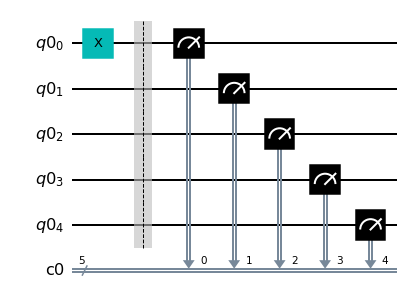

In [3]:
print(state_labels)
# 量子ゲートを描画する。
meas_calibs[1].draw('mpl')

[[0.802 0.165 0.042 ... 0.    0.    0.   ]
 [0.092 0.717 0.004 ... 0.    0.    0.   ]
 [0.014 0.001 0.777 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.655 0.002 0.024]
 [0.    0.    0.    ... 0.004 0.684 0.134]
 [0.    0.    0.    ... 0.005 0.072 0.629]]


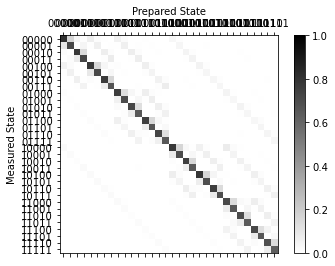

In [4]:
# 校正用の行列を生成してプロットする。
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list)
# 表示＆プロットする。
print(meas_fitter .cal_matrix)
meas_fitter.plot_calibration()

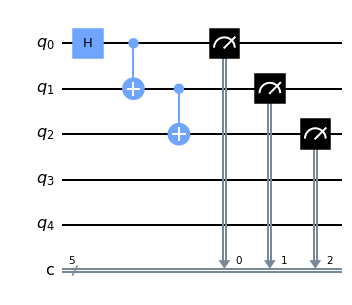

In [6]:
# GHZ状態を作成、測定する
# 量子ビットを用意する。
qc = QuantumCircuit(5, 5)
# 量子のもつれ状態を作成する。
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
# 測定ゲートを追加する。
qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)
# 量子ゲートを描く
qc.draw('mpl')

In [7]:
# アカウント情報を読み込む
IBMQ.load_account()
# 設定を適用する
provider = IBMQ.get_provider(group='open', project='main')
# マシンを選択する。
backend = provider.get_backend('ibmq_5_yorktown')
# ジョブを実行する
job = qiskit.execute(qc, backend=backend, shots=1000)
results = job.result()
print(results.get_counts())

ibmqfactory.load_account:WARNING:2021-06-26 17:46:24,323: Credentials are already in use. The existing account in the session will be replaced.


{'00000': 413, '00001': 72, '00010': 10, '00011': 41, '00100': 37, '00101': 22, '00110': 74, '00111': 331}


In [8]:
# 測定された生の値
raw_counts = results.get_counts()

In [10]:
# 校正行列により補正した値
meas_filter = meas_fitter.filter
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)
# プロットする。
plot_histogram([raw_counts , mitigated_counts], legend=['raw', 'mitigated'])

AttributeError: 'MeasurementFilter' object has no attribute 'filter'